### Mixing our ideas and others (not all) from the forum

**Steps:**
1. Remove zero- and near-zero-variance features.
2. Compute mean, std, etc *per row*.
3. Train a simple lgb model on the remaining original features and determine 100 most important.
4. Create a dataframe of polynomial features of these 100 most important.
5. Assemble dataset of polynomial+statistical properties, *i.e.*, combinations of the 100 most relevant plus aggregated properties of ALL.
6. Retrain lgb:
    - `min_data_in_leaf`: 50
    - `objective`: regression
    - `num_leaves`: 31
    - `learning_rate`: 0.05
    - `metric`: rmse
    - `lambda_l2`: 0.1
    - `lambda_l1`: 0.007
    - `feature_fraction`: 0.1
    - 1.369, std 0.02
    *****
    - `learning_rate`: 0.01
    - `feature_fraction`: 0.01
    - 1.367, std 0.03

In [2]:
# misc
import warnings
warnings.filterwarnings('ignore')
import gc

# basic imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
sns.set(palette='colorblind')

# processing
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import VarianceThreshold

import shap

# models
import lightgbm as lgb

In [3]:
train_data = pd.read_csv('../data/train.csv')
test_data = pd.read_csv('../data/test.csv')

### Preprocessing

#### Removing target

In [4]:
# remove target and ID columns
target = train_data.target
train_data = train_data.drop(['target', 'ID'], axis=1)
test_ID = test_data.ID
test_data = test_data.drop(['ID'], axis=1)

#### Variance threshold

In [27]:
properties_train = train_data.describe()
max_std = properties_train.transpose()['std'].max()

threshold_var = max_std/1000.

In [32]:
vt = VarianceThreshold(threshold=threshold_var)
vt.fit(train_data)
selected_columns = train_data.columns[vt.get_support(indices=True)]

In [34]:
train_novar = train_data[selected_columns]
test_novar = test_data[selected_columns]

In [35]:
print('Remaining columns: %i' % len(selected_columns))

Remaining columns: 4725


#### Statistical properties

A first try. People in the forum recommend only considering non-zero values (right now medians are zero).

In [41]:
tr_means = train_novar.mean(axis=1)
#tr_medians = train_novar.median(axis=1)
tr_stds = train_novar.std(axis=1)
tr_skews = train_novar.skew(axis=1)
tr_maxs = train_novar.max(axis=1)

In [42]:
tst_means = test_novar.mean(axis=1)
#tst_medians = test_novar.median(axis=1)
tst_stds = test_novar.std(axis=1)
tst_skews = test_novar.skew(axis=1)
tst_maxs = test_novar.max(axis=1)

In [47]:
stat_train = pd.concat([tr_means, tr_stds, tr_skews, tr_maxs], axis=1)
stat_test = pd.concat([tst_means, tst_stds, tst_skews, tst_maxs], axis=1)

#### SHAP

In [52]:
#transform to log
log_features_train = np.log1p(train_novar)
log_features_test = np.log1p(test_novar)
log_target = np.log1p(target)

In [55]:
# CV folds
kf = KFold(n_splits=10, shuffle=True)
n_splits = kf.get_n_splits()

In [64]:
# model parameters
params = {'learning_rate':0.5, 'metric':'rmse', 'max_bin':63, 'device':'gpu'}

In [65]:
shap_values = np.zeros((log_features_train.shape[0],log_features_train.shape[1]+1))

for train_index, test_index in kf.split(log_features_train):
    
    X_tr, X_tst = log_features_train.values[train_index], log_features_train.values[test_index]
    y_tr, y_tst = log_target[train_index], log_target[test_index]
    
    train_set = lgb.Dataset(X_tr, label=y_tr)
    valid_set = lgb.Dataset(X_tst, label=y_tst, reference=train_set)
    
    bst = lgb.train(params, train_set, num_boost_round=50, valid_sets=[train_set, valid_set], early_stopping_rounds=5,
                    verbose_eval=1)

    shap_values += shap.TreeExplainer(bst).shap_values(log_features_train.values)/n_splits

[1]	training's rmse: 1.55576	valid_1's rmse: 1.62489
Training until validation scores don't improve for 5 rounds.
[2]	training's rmse: 1.44063	valid_1's rmse: 1.55138
[3]	training's rmse: 1.36332	valid_1's rmse: 1.52302
[4]	training's rmse: 1.2998	valid_1's rmse: 1.50437
[5]	training's rmse: 1.25319	valid_1's rmse: 1.50248
[6]	training's rmse: 1.21124	valid_1's rmse: 1.48032
[7]	training's rmse: 1.17534	valid_1's rmse: 1.49762
[8]	training's rmse: 1.14446	valid_1's rmse: 1.50939
[9]	training's rmse: 1.11789	valid_1's rmse: 1.51973
[10]	training's rmse: 1.09383	valid_1's rmse: 1.51905
[11]	training's rmse: 1.06993	valid_1's rmse: 1.52657
Early stopping, best iteration is:
[6]	training's rmse: 1.21124	valid_1's rmse: 1.48032
[1]	training's rmse: 1.54631	valid_1's rmse: 1.64778
Training until validation scores don't improve for 5 rounds.
[2]	training's rmse: 1.42596	valid_1's rmse: 1.58801
[3]	training's rmse: 1.34705	valid_1's rmse: 1.56206
[4]	training's rmse: 1.2886	valid_1's rmse: 1.5

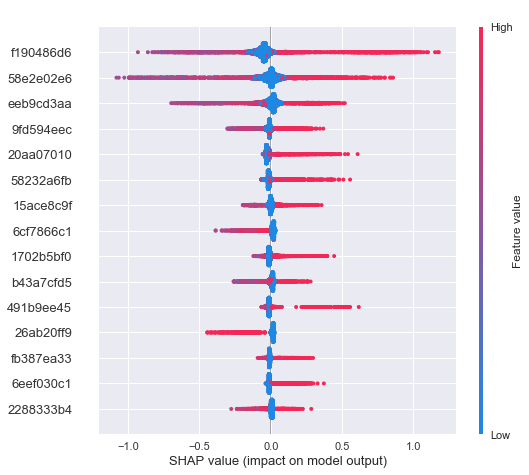

In [67]:
shap.summary_plot(shap_values, log_features_train, max_display=15, plot_type='dot')

In [71]:
sorted_columns = np.argsort(np.sum(np.abs(shap_values), axis=0)[:-1])[::-1]
most_relevant = train_novar.columns[sorted_columns[:100]]

In [76]:
log_features_train = log_features_train[most_relevant]
log_features_test = log_features_test[most_relevant]

In [77]:
print('Remaining columns: %i' % log_features_train.shape[1])

Remaining columns: 100


#### Polynomial

In [78]:
#scaling
scaler = StandardScaler()

log_features_train = scaler.fit_transform(log_features_train)
log_features_test = scaler.transform(log_features_test)

In [79]:
poly = PolynomialFeatures(2, interaction_only=True, include_bias=False)

In [80]:
poly_train = poly.fit_transform(log_features_train)
poly_test = poly.fit_transform(log_features_test)

#### Assembly

In [86]:
train_final = np.hstack((poly_train, stat_train))
test_final = np.hstack((poly_test, stat_test))

In [87]:
del train_data, test_data, train_novar, test_novar, log_features_train, log_features_test
gc.collect()

21023

In [88]:
print('Final number of features: %i' % train_final.shape[1])

Final number of features: 5054


### lgb

In [163]:
# CV folds
kf = KFold(n_splits=10, shuffle=True)
n_splits = kf.get_n_splits()

In [202]:
# model parameters
params = {'boosting': 'gbdt', 'objective':'regression', 'num_leaves':31, 'learning_rate':0.01, 'metric':'rmse', 'max_bin':63, 
          'lambda_l2': 0.1, 'device':'gpu', 'feature_fraction': 0.01, 'lambda_l1': 0.007, 'min_data_in_leaf': 20}

In [ ]:
submission = pd.DataFrame.from_dict({'ID': test_ID, 'target': np.zeros(test_ID.shape[0])})
    
errors = []

for train_index, test_index in kf.split(train_final):

    X_tr, X_tst = train_final[train_index], train_final[test_index]
    y_tr, y_tst = log_target[train_index], log_target[test_index]

    train_set = lgb.Dataset(X_tr, label=y_tr)
    valid_set = lgb.Dataset(X_tst, label=y_tst, reference=train_set)

    bst = lgb.train(params, train_set, num_boost_round=5000, valid_sets=[train_set, valid_set], early_stopping_rounds=200, verbose_eval=100)

    y_val = bst.predict(X_tst, num_iteration=bst.best_iteration)

    rmsle = np.sqrt(mean_squared_error(y_tst, y_val))

    print('RMSLE: %.5f' % rmsle)

    errors.append(rmsle)

    submission.target = submission.target + np.expm1(bst.predict(test_final, num_iteration=bst.best_iteration))/n_splits

print('\n Fold mean of RMSLE: %.5f' % np.mean(errors))
print('\n Fold std of RMSLE: %.5f' % np.std(errors))

In [184]:
submission.head()

,ID,target
0,000137c73,1.664715e+06
1,00021489f,2.126146e+06
2,0004d7953,1.963233e+06
3,00056a333,5.521954e+06
4,00056d8eb,2.172619e+06


In [185]:
submission.to_csv('../submission_files/lgb_1367_003.csv', index=False)

### NN

In [ ]:
submission = pd.DataFrame.from_dict({'ID': test_ID, 'target': np.zeros(test_data.shape[0])})

mean_of_errors = 0.

for train_index, test_index in kf.split(log_features_train):
        
    X_tr, X_tst = log_features_train[train_index], log_features_train[test_index]
    y_tr, y_tst = log_target[train_index], log_target[test_index]
        
    model = Sequential()
    model.add(Dense(2, input_dim=X_tr.shape[1], activation='tanh'))
    model.add(Dense(1))
    
    sgd = SGD(lr=0.05, momentum=0.1)
    model.compile(optimizer=sgd, loss='mse', metrics=['mse'])
    
    model.fit(X_tr, y_tr, validation_data=(X_tst, y_tst), epochs=10)
    
    y_val = model.predict(X_tst)
    
    rmsle = np.sqrt(mean_squared_error(y_tst, y_val))
    
    print('RMSLE: %.5f' % rmsle)
    
    mean_of_errors += rmsle/n_splits
        
    submission.target = submission.target + np.expm1(model.predict(log_features_test)[:,0])/n_splits
    
print('\n Fold mean of RMSLE: %.5f' % mean_of_errors)

In [ ]:
submission.head()

In [ ]:
submission.to_csv('../submission_files/nn_log_std_10fold.csv', index=False)

### xgb

In [36]:
# model parameters

params = {'booster': 'gbtree', 'learning_rate':0.01, 'colsample_bytree': 0.075, 'eval_metric':'rmse', 'lambda': 2.5,
          'alpha': 0.05}

In [29]:
submission = pd.DataFrame.from_dict({'ID': test_ID, 'target': np.zeros(test_data.shape[0])})

mean_of_errors = 0.

test_set = xgb.DMatrix(log_features_test)

for train_index, test_index in kf.split(log_features_train):
        
    X_tr, X_tst = log_features_train[train_index], log_features_train[test_index]
    y_tr, y_tst = log_target[train_index], log_target[test_index]
        
    train_set = xgb.DMatrix(X_tr, label=y_tr)
    valid_set = xgb.DMatrix(X_tst, label=y_tst)
        
    bst = xgb.train(params, train_set, num_boost_round=10000, evals=[(train_set, 'train'), (valid_set, 'val')],
                    early_stopping_rounds=250, verbose_eval=100)
    
    y_val = bst.predict(valid_set, ntree_limit=bst.best_ntree_limit)
    
    rmsle = np.sqrt(mean_squared_error(y_tst, y_val))
    
    print('RMSLE: %.5f' % rmsle)
    
    mean_of_errors += rmsle/n_splits
        
    submission.target = submission.target + np.expm1(bst.predict(test_set, ntree_limit=bst.best_ntree_limit))/n_splits
        
print('\n Fold mean of RMSLE: %.5f' % mean_of_errors)

[0]	train-rmse:13.9542	val-rmse:14.0191
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 250 rounds.
[100]	train-rmse:5.34451	val-rmse:5.4152
[200]	train-rmse:2.3982	val-rmse:2.50345
[300]	train-rmse:1.54827	val-rmse:1.70507
[400]	train-rmse:1.3337	val-rmse:1.53405
[500]	train-rmse:1.26195	val-rmse:1.4941
[600]	train-rmse:1.22277	val-rmse:1.47827
[700]	train-rmse:1.19246	val-rmse:1.46935
[800]	train-rmse:1.16364	val-rmse:1.46287
[900]	train-rmse:1.14055	val-rmse:1.45998
[1000]	train-rmse:1.11797	val-rmse:1.45592
[1100]	train-rmse:1.1002	val-rmse:1.45208
[1200]	train-rmse:1.0823	val-rmse:1.44961
[1300]	train-rmse:1.06725	val-rmse:1.44739
[1400]	train-rmse:1.05271	val-rmse:1.44557
[1500]	train-rmse:1.03737	val-rmse:1.44286
[1600]	train-rmse:1.02501	val-rmse:1.44059
[1700]	train-rmse:1.01247	val-rmse:1.43869
[1800]	train-rmse:1.00117	val-rmse:1.4373
[1900]	train-rmse:0.991369	val-rmse:1.43542
[2000]	train-rms

[900]	train-rmse:1.15196	val-rmse:1.44828
[1000]	train-rmse:1.12895	val-rmse:1.44483
[1100]	train-rmse:1.10997	val-rmse:1.44211
[1200]	train-rmse:1.09167	val-rmse:1.44075
[1300]	train-rmse:1.07603	val-rmse:1.4394
[1400]	train-rmse:1.06092	val-rmse:1.43712
[1500]	train-rmse:1.04649	val-rmse:1.43446
[1600]	train-rmse:1.03442	val-rmse:1.43396
[1700]	train-rmse:1.02204	val-rmse:1.43341
[1800]	train-rmse:1.01036	val-rmse:1.43274
[1900]	train-rmse:0.998218	val-rmse:1.43157
[2000]	train-rmse:0.98804	val-rmse:1.43042
[2100]	train-rmse:0.978273	val-rmse:1.42967
[2200]	train-rmse:0.967821	val-rmse:1.42895
[2300]	train-rmse:0.95882	val-rmse:1.42821
[2400]	train-rmse:0.949229	val-rmse:1.42776
[2500]	train-rmse:0.940219	val-rmse:1.42687
[2600]	train-rmse:0.931617	val-rmse:1.42612
[2700]	train-rmse:0.922178	val-rmse:1.42486
[2800]	train-rmse:0.914322	val-rmse:1.4249
[2900]	train-rmse:0.905728	val-rmse:1.4245
[3000]	train-rmse:0.898473	val-rmse:1.42428
[3100]	train-rmse:0.891371	val-rmse:1.42419
[320

[1400]	train-rmse:1.07189	val-rmse:1.37509
[1500]	train-rmse:1.05701	val-rmse:1.37329
[1600]	train-rmse:1.04411	val-rmse:1.37227
[1700]	train-rmse:1.03204	val-rmse:1.37116
[1800]	train-rmse:1.02058	val-rmse:1.37106
[1900]	train-rmse:1.00954	val-rmse:1.36997
[2000]	train-rmse:0.997477	val-rmse:1.36939
[2100]	train-rmse:0.987115	val-rmse:1.3692
[2200]	train-rmse:0.976672	val-rmse:1.3685
[2300]	train-rmse:0.967697	val-rmse:1.36841
[2400]	train-rmse:0.958426	val-rmse:1.36847
[2500]	train-rmse:0.949589	val-rmse:1.36886
Stopping. Best iteration:
[2285]	train-rmse:0.96916	val-rmse:1.36823

RMSLE: 1.36823

 Fold mean of RMSLE: 1.42381


In [38]:
submission.head()

,ID,target
0,000137c73,1.900761e+06
1,00021489f,1.871472e+06
2,0004d7953,1.286523e+06
3,00056a333,9.247469e+06
4,00056d8eb,1.903365e+06


In [39]:
submission.to_csv('../submission_files/xgb_log_std_10fold.csv', index=False)